# General interpolation from polar to pseudo-polar

Uses `scipy`.

The new definition of the pseudo-polar Fourier transform is:
$$
\forall (k, l) \in \llbracket -n/2, n/2 \rrbracket \times \llbracket -n/2, n/2 \rrbracket, \widehat{I}_h (k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{-\frac{2lk}{n}u + kv}{n + 1} \right) \\
\forall (k, l) \in \llbracket -n/2, n/2 \rrbracket \times \llbracket -n/2, n/2 \rrbracket, \widehat{I}_v (k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku - \frac{2lk}{n}v }{n+1} \right)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ppfft.tools.grids import domain

## Grids

In [2]:
def horizontal_grid(n: int) -> np.ndarray:
    dom = domain(n + 1)
    horizontal_x = - 2 * dom[None, :] * dom[:, None] / (n * (n + 1))
    horizontal_y = np.tile(dom[:, None], (1, n + 1)) / (n + 1)
    return horizontal_x, horizontal_y


def vertical_grid(n):
    horizontal_x, horizontal_y = horizontal_grid(n)
    return horizontal_y, horizontal_x


def polar_grid(thetas, n_r):
    rs = domain(n_r) / n_r

    polar_x = np.cos(thetas)[:, None] * rs[None, :]
    polar_y = np.sin(thetas)[:, None] * rs[None, :]

    return polar_x, polar_y

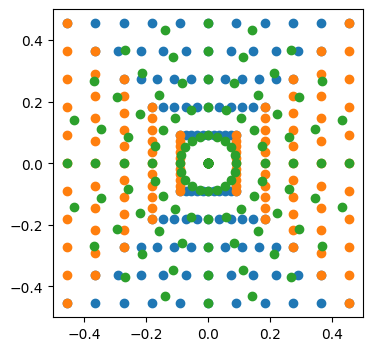

In [3]:
n = 10
hori_x, hori_y = horizontal_grid(n)
vert_x, vert_y = vertical_grid(n)

thetas = np.linspace(0, np.pi, num=n, endpoint=False)
polar_x, polar_y = polar_grid(thetas, n + 1)

fig = plt.figure(figsize=(4, 4))
plt.scatter(np.ravel(hori_x), np.ravel(hori_y))
plt.scatter(np.ravel(vert_x), np.ravel(vert_y))
plt.scatter(np.ravel(polar_x), np.ravel(polar_y))
plt.show()

## Interpolation

In [4]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator

In [5]:
def direct_2d_interp(polar_ft, polar_x, polar_y, n, interp_fun=CloughTocher2DInterpolator):
    """
    2d interpolation from polar gird to pseudo-polar.

    ## Parameters
    polar_ft : np.ndarray
        Samples of the polar Fourier transform. Shape: (n_theta, n_r).
    x : np.ndarray
        x coordinates of the polar grid. Shape: (n_theta, n_r).
    y : np.ndarray
        y coordinates of the polar grid. Shape: (n_theta, n_r).
    n : int
        Size of the original image.
    interp_fun : class, optional
        2d Interpolator used.

    ## Returns
    hori_ppfft : np.ndarray
        Inteprolated horizontal ppfft. Shape: (n+1, n+1).
    vert_ppfft : np.ndarray
        Inteprolated vertical ppfft. Shape: (n+1, n+1).
    """
    points = np.stack((polar_x.flatten(), polar_y.flatten()), axis=-1)
    interpolator = interp_fun(points, polar_ft.flatten(), fill_value=0)

    hori_x, hori_y = horizontal_grid(n)

    hori_ppfft = interpolator(hori_x, hori_y)
    vert_ppfft = interpolator(hori_y, hori_x)

    return hori_ppfft, vert_ppfft

In [6]:
def polar_fourier_transform(im, thetas, n_r):
    n = len(im)
    rs = domain(n_r) / n_r
    u, v = domain(n), domain(n)

    cos = -2j * np.pi * np.einsum("k,u,l->kul", rs, u, np.cos(thetas))
    sin = -2j * np.pi * np.einsum("k,v,l->kvl", rs, v, np.sin(thetas))

    res = np.einsum("uv,kul,kvl->lk", im, np.exp(cos), np.exp(sin))

    return res

## Try with sinogram

In [87]:
from silx.image.projection import Projection

from ppfft.ppfft.new_ppfft import new_ppfft
from ppfft.tools.pad import pad
from ppfft.tools.phantom_generator import generate_phantom
from ppfft.inverse.new_direct_inversion import precompute_onion_peeling, new_direct_inversion
from ppfft.tools.new_fft import new_fft, new_fft2, new_ifft2

In [112]:
n = 400
precomputations = precompute_onion_peeling(n)

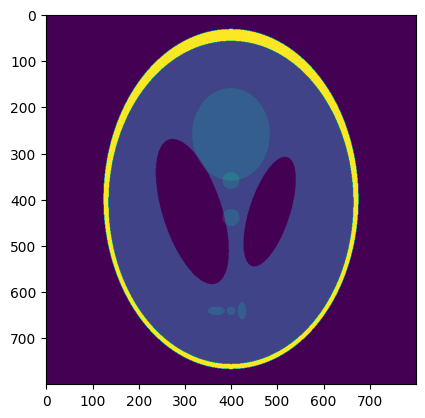

In [113]:
im = generate_phantom(n)
plt.imshow(im)

In [114]:
angles = np.pi * np.arange(0, n) / n
n_r = n + 1
polar_ft = polar_fourier_transform(im, thetas=angles, n_r=n_r)

In [102]:
polar_x, polar_y = polar_grid(thetas=angles, n_r=n_r)
hori, vert = direct_2d_interp(polar_ft, polar_x, polar_y, n)

In [103]:
true_hori, true_vert = new_ppfft(im)

/tmp/ipykernel_2769389/3924421514.py:3: RuntimeWarning: divide by zero encountered in log10
  axes[0, 0].imshow(np.log10(np.abs(hori.real[n//2:])))
/tmp/ipykernel_2769389/3924421514.py:6: RuntimeWarning: divide by zero encountered in log10
  axes[0, 1].imshow(np.log10(np.abs(hori.imag[n//2:])))
/tmp/ipykernel_2769389/3924421514.py:7: RuntimeWarning: divide by zero encountered in log10
  axes[1, 1].imshow(np.log10(np.abs(true_hori.imag[n//2:])))


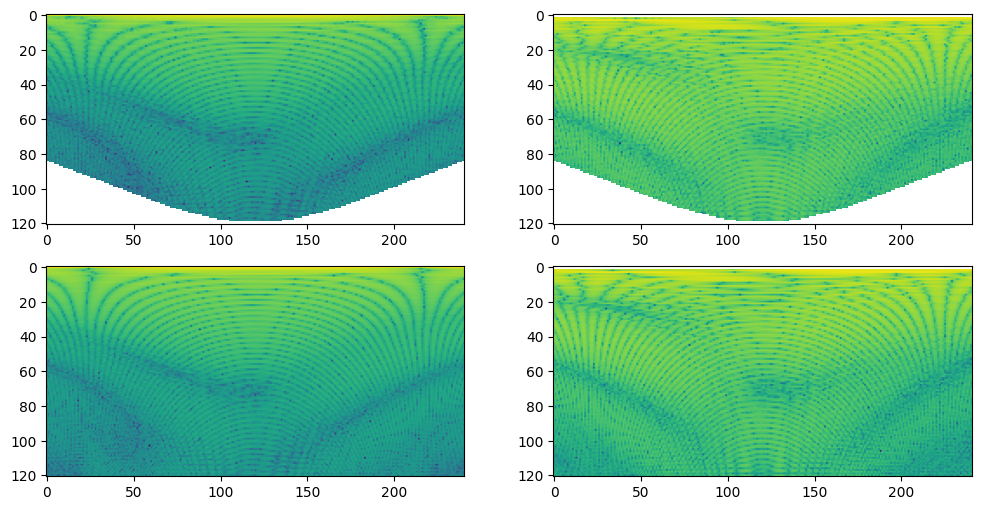

In [104]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

axes[0, 0].imshow(np.log10(np.abs(hori.real[n//2:])))
axes[1, 0].imshow(np.log10(np.abs(true_hori.real[n//2:])))

axes[0, 1].imshow(np.log10(np.abs(hori.imag[n//2:])))
axes[1, 1].imshow(np.log10(np.abs(true_hori.imag[n//2:])))

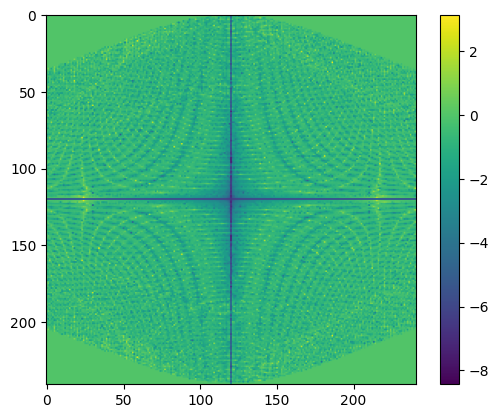

In [105]:
plt.imshow(np.log10(np.abs(hori.real - true_hori.real)) - np.log10(np.abs(true_hori.real)))
plt.colorbar()

/tmp/ipykernel_2769389/2045375449.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(hori.imag - true_hori.imag)) - np.log10(np.abs(true_hori.imag)))
/tmp/ipykernel_2769389/2045375449.py:1: RuntimeWarning: invalid value encountered in subtract
  plt.imshow(np.log10(np.abs(hori.imag - true_hori.imag)) - np.log10(np.abs(true_hori.imag)))


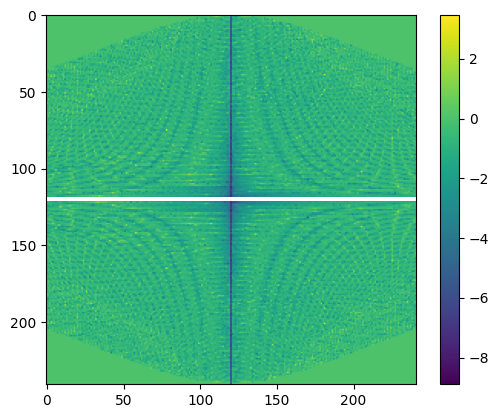

In [106]:
plt.imshow(np.log10(np.abs(hori.imag - true_hori.imag)) - np.log10(np.abs(true_hori.imag)))
plt.colorbar()

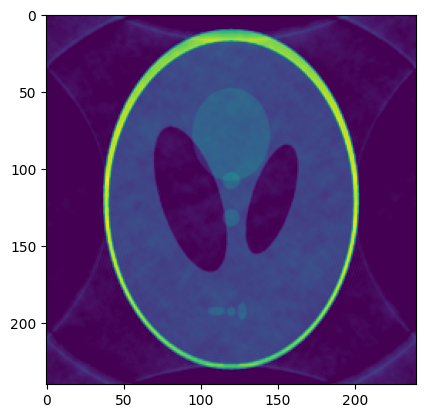

In [111]:
sol = new_direct_inversion(hori, vert, precomputations)
plt.imshow(sol, vmin=0, vmax=1)

In [ ]:
n = 800
im = generate_phantom(n)

thetas = np.linspace(-np.pi/2, np.pi/2, endpoint=False, num=n)

proj = Projection(im.shape, angles=thetas)
sinogram = proj.projection(im)
pad_sino = pad(sinogram, (n, 2 * n)) # zero-padding the sinogram to increase the radial samples
fft_sinogram = new_fft(pad_sino)

In [197]:
precomputations = precompute_onion_peeling(n)

In [198]:
polar_x, polar_y = polar_grid(np.pi / 2 + thetas, 2 * n)
hori, vert = direct_2d_interp(fft_sinogram, polar_x, polar_y, n)

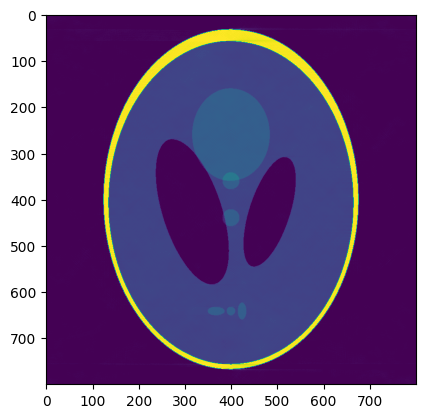

In [199]:
sol = new_direct_inversion(hori, vert, precomputations)
plt.imshow(sol, vmin=0, vmax=1)

In [200]:
from ppfft.reconstruction.new_reconstruction import precompute_onion_peeling, new_reconstruction

In [201]:
n = 300
precomputations = precompute_onion_peeling(n)
im = generate_phantom(n)

In [202]:
thetas = np.linspace(-np.pi/2, np.pi/2, endpoint=True, num=n+1)
proj = Projection(im.shape, angles=thetas)
sinogram = proj.projection(im)

In [203]:
sol = new_reconstruction(sinogram, thetas, precomputations, oversampling=3*n)

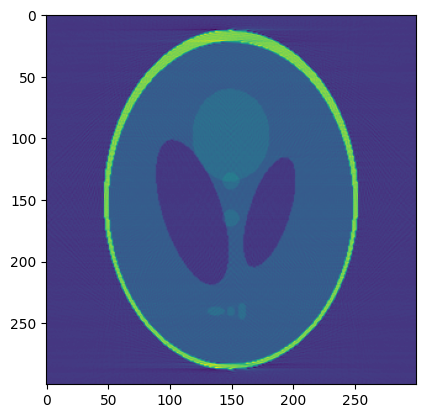

In [204]:
plt.imshow(sol)